In [1]:
import torch
import numpy as np
import hydroeval as he
import delorean
import matplotlib.pyplot as plt

In [2]:
class dset_maker(torch.utils.data.Dataset):
    def __init__(self,x,y,z,l):
        if l == 0:
            self.x = x[:z]
            self.y = y[:z]
            self.yog = self.y[:z]
            self.std,self.mean = torch.std_mean(self.y)
            self.y = (self.y - self.mean)/self.std
        else:
            self.x = x[:z-l]
            self.y = y[l:z]
            self.yog = self.y[:z]
            self.std,self.mean = torch.std_mean(self.y)
            self.y = (self.y - self.mean)/self.std
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        y = self.y[idx].to('cuda')
        std = self.std[idx].to('cuda')
        mean = self.mean[idx].to('cuda')
        return x, y, yog, std, mean
    def __len__(self):
        return self.x.shape[0]

class a_linear(torch.nn.Module):
    def __init__(self,XXXX,XX):
        super(a_linear,self).__init__()
        self.XXXX = XXXX
        self.XX = XX
        self.relu = torch.nn.ReLU(inplace=True)
        self.linear1 = torch.nn.Linear(self.XXXX,3) ### this is what gets changed based on important switch
        self.linear2 = torch.nn.Linear(3,self.XX)
    def forward(self, x):
        o = self.relu(self.linear1(x.view(x.size(0),-1)))
        o = self.linear2(o)
        # o = self.relu(self.linear3(o))
        # o = self.relu(self.linear4(o))
        return o

class a_simp(torch.nn.Module):
    def __init__(self,XXXX,XX):
        super(a_simp,self).__init__()
        self.XXXX = XXXX
        self.XX = XX
        self.relu = torch.nn.ReLU(inplace=True)
        self.linear1 = torch.nn.Linear(self.XXXX,24) ### this is what gets changed based on important switch
        self.linear2 = torch.nn.Linear(24,12)
        self.linear3 = torch.nn.Linear(50,20)
        self.linear4 = torch.nn.Linear(20,10)
        self.linear5 = torch.nn.Linear(12,self.XX)
    def forward(self, x):
        o = self.linear1(x.view(x.size(0),-1))
        o = self.relu(self.linear2(o))
        # o = self.relu(self.linear3(o))
        # o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o
    
class a(torch.nn.Module):
    def __init__(self,XXXX,XX):
        super(a,self).__init__()
        chonz = 16
        
        #i/o sizes
        self.XXXX = XXXX
        self.XX = XX
        # into conv 
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=chonz, kernel_size=3, padding=1, bias=False)
        self.relu = torch.nn.ReLU(inplace=True)
        # residual / latent space layers
        hidden_layers = []
        for i in range(2):
            hidden_layers.append(torch.nn.Conv2d(in_channels=chonz, out_channels=chonz, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(chonz))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out of conv into perceptronesque / encoder
        self.conv3 = torch.nn.Conv2d(in_channels=chonz, out_channels=1, kernel_size=3, padding=1, bias=False) #anything below this is for shrinking 
        self.linear1 = torch.nn.Linear(self.XXXX,100) ### this is what gets changed based on important switch
        self.linear2 = torch.nn.Linear(100,50)
        self.linear3 = torch.nn.Linear(50,20)
        self.linear4 = torch.nn.Linear(20,10)
        self.linear5 = torch.nn.Linear(10,self.XX)
     
    #calls the layers explained in __init__ above
    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.mid_layer(out1)
        o = self.conv3(out+out1)
        o = self.linear1(o.view(o.size(0),-1))
        o = self.relu(self.linear2(o))
        o = self.relu(self.linear3(o))
        o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o


In [3]:
torch.cuda.empty_cache()
print(f'( {torch.cuda.device_count()} ) {torch.cuda.get_device_name(0)} available \n'.lower())

imz = torch.load('../../data/traintest/COL_MOGL_ZSCORE_traintest.pt')
sf = torch.load('../../data/traintest/COL_STFL_traintest.pt')
lag = 0
dset = dset_maker(imz,sf,imz.shape[0],lag)
cube_height = dset.x.shape[2]
cube_width = dset.x.shape[3]
epochs = 40
stop = 1
data_split =.7
batch_size = 2
criterion = torch.nn.MSELoss()

train_size = int(data_split*len(dset))
valid_size = int(0.5*(len(dset) - train_size))
test_size = int(len(dset)-train_size-valid_size)

train_dset = torch.utils.data.TensorDataset(dset.x[:train_size],
                                            dset.y[:train_size])
valid_dset = torch.utils.data.TensorDataset(dset.x[train_size: train_size + valid_size],
                                            dset.y[train_size: train_size + valid_size])
test_dset = torch.utils.data.TensorDataset(dset.x[train_size + valid_size:],
                                           dset.y[train_size + valid_size:],
                                           dset.yog[train_size + valid_size:])
print(f"train / val / test dataset lengths: {len(train_dset)},{len(valid_dset)},{len(test_dset)}")

train_dataloader = torch.utils.data.DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=False)

model = a(dset.x.shape[2] * dset.x.shape[3],dset.y.shape[-1])
model.cuda()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

( 1 ) nvidia geforce gtx 1080 ti available 

train / val / test dataset lengths: 147,31,32


In [4]:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)

# redundantly empty cache
torch.cuda.empty_cache()
print(f'( {torch.cuda.device_count()} ) {torch.cuda.get_device_name(0)} available \n'.lower())


t0 = delorean.Delorean().shift('US/Eastern').datetime
print(f"training began @ {t0.strftime('%Y-%m-%d %H:%M:%S')}")

# print(f'Training started at {datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')}')
t_loss = []
v_loss = []
e_time = []
nse_during = []
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    train_pred = torch.empty((0,1)).to('cuda')
    train_y = torch.empty((0,1)).to('cuda')
    
    val_pred = torch.empty((0,1)).to('cuda')
    val_y = torch.empty((0,1)).to('cuda')
    
    t00 = delorean.Delorean().shift('US/Eastern').datetime
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        predicted = model(x)   
        train_pred = torch.cat((train_pred,predicted.reshape(-1,1)))
        train_y = torch.cat((train_y,y.reshape(-1,1)))
        loss = criterion(predicted.reshape(-1),y.reshape(-1))
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        xx = xx.cuda()
        yy = yy.cuda()
        v_pred = model(xx)
        loss2 = criterion(v_pred.reshape(-1),yy.reshape(-1))
        v_e_loss += loss2.item()
        val_pred = torch.cat((val_pred,v_pred.reshape(-1,1)))
        val_y = torch.cat((val_y,yy.reshape(-1,1)))
        
        
    nse_epoch_train = he.evaluator(he.nse,train_pred.cpu().detach().numpy(),train_y.cpu().detach().numpy())
    nse_epoch_valid = he.evaluator(he.nse,val_pred.cpu().detach().numpy(),val_y.cpu().detach().numpy())
    if i % 10 == 0:
        print(f"nse, train / val, epoch {i}: {np.around(nse_epoch_train,2)} / {np.around(nse_epoch_valid,2)}")
    nse_during.append(nse_epoch_train)
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = delorean.Delorean().shift('US/Eastern').datetime
    e_time.append(t11-t00)
    if nse_epoch_train > stop:
        break
t1 = delorean.Delorean().shift('US/Eastern').datetime
t2 = t1 - t0
t2 = t2.seconds / 60
print(f"training ended @ {t1.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"training time {round(t2,3)} (minutes)")


( 1 ) nvidia geforce gtx 1080 ti available 

training began @ 2023-02-21 08:50:56
nse, train / val, epoch 0: [0.22] / [0.25]
nse, train / val, epoch 10: [0.66] / [0.64]
nse, train / val, epoch 20: [0.86] / [0.81]
nse, train / val, epoch 30: [0.94] / [0.85]
training ended @ 2023-02-21 08:51:37
training time 0.683 (minutes)


In [6]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dset, batch_size=1, shuffle=False)

test_pred = torch.empty((0,test_dset.tensors[-1].shape[-1])).to('cuda')

with torch.no_grad():
    for xx,yy,_ in test_dataloader:
        pred = model(xx.cuda())
        test_pred = torch.cat((test_pred,pred))

test_pred.shape
# test_predictions = np.asarray(test_predictions)
# test_predictions.shape
# nse_test = he.evaluator(he.nse,test_pred.cpu().detach().numpy().reshape(-1,1),test_yy.cpu().detach().numpy().reshape(-1,1)) 

# test_streamflows = torch.Tensor([(x*dset.std)+dset.mean for x in test_pred])
model_sf = (test_pred * dset.std) + dset.mean
model_sf.shape


torch.Size([32, 7])

In [8]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dset, batch_size=1, shuffle=False)

test_pred = torch.empty((0,test_dset.tensors[-1].shape[-1])).to('cuda')
test_yy = torch.empty((0,1,1,test_dset.tensors[-1].shape[-1])).to('cuda')

with torch.no_grad():
    for xx,yy,yog in test_dataloader:
        pred = model(xx.cuda())
        test_pred = torch.cat((test_pred,pred))
        test_yy = torch.cat((test_yy,yog.cuda()))

print(test_yy.shape)
print(test_pred.shape)
# test_predictions = np.asarray(test_predictions)
# test_predictions.shape



nse_test = he.evaluator(he.nse,model_sf.cpu().detach().numpy().reshape(-1,1),test_yy.cpu().detach().numpy().reshape(-1,1)) 
print(nse_test)

torch.Size([32, 1, 1, 7])
torch.Size([32, 7])
[0.83616003]


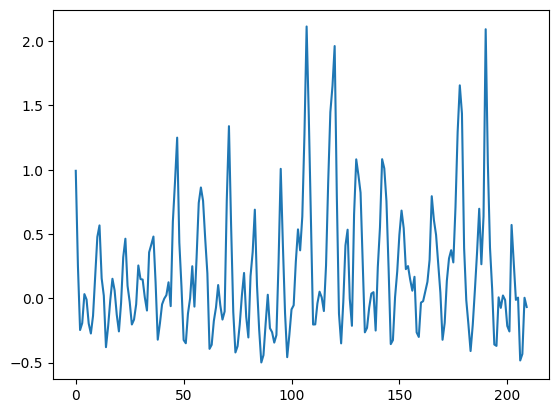

In [9]:
plt.plot(dset.y[:,0,0,-6])

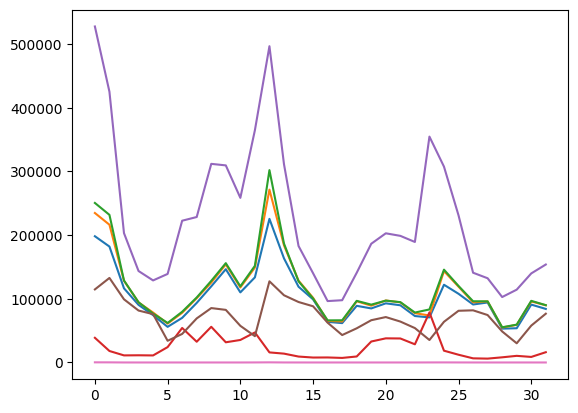

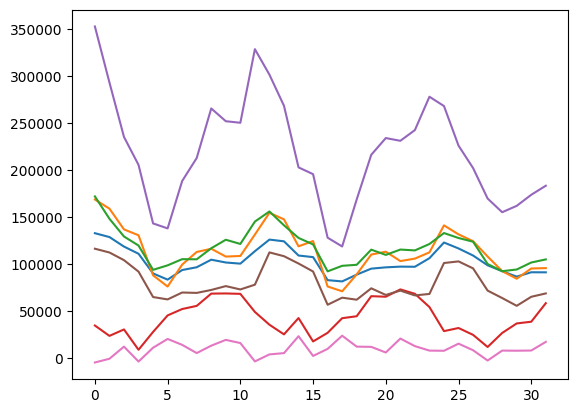

In [10]:
model_sf.shape

plt.plot(test_dset.tensors[-1].cpu().squeeze())
plt.figure()
plt.plot(model_sf.cpu().squeeze())

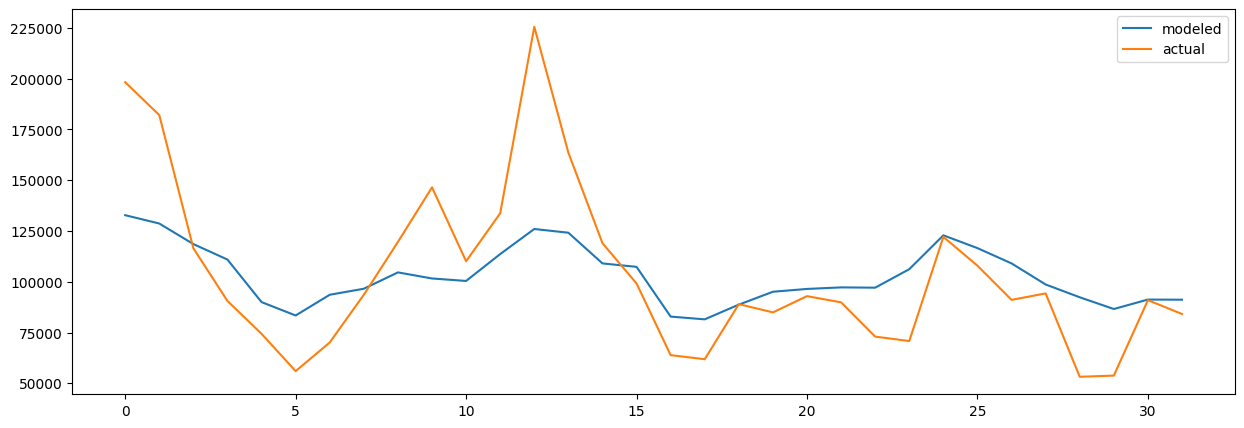

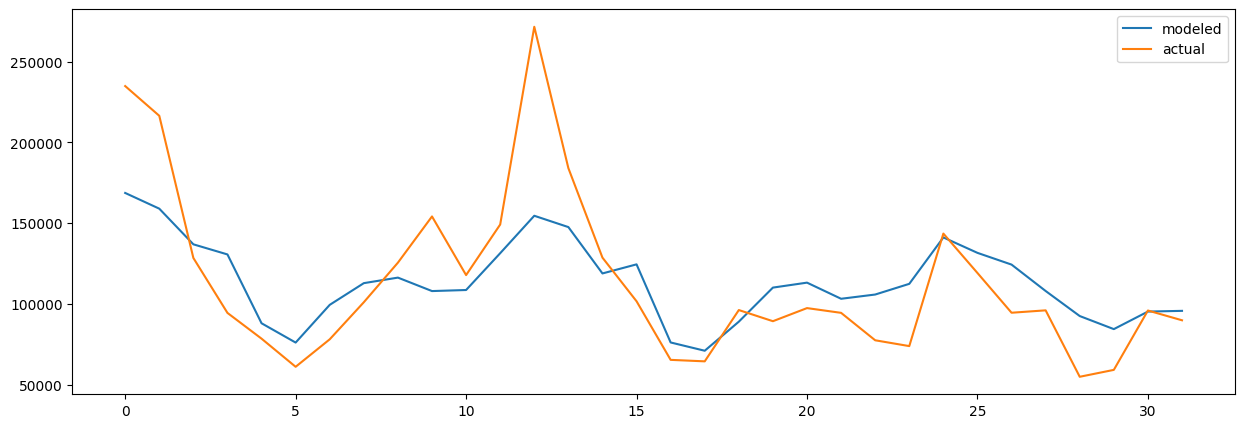

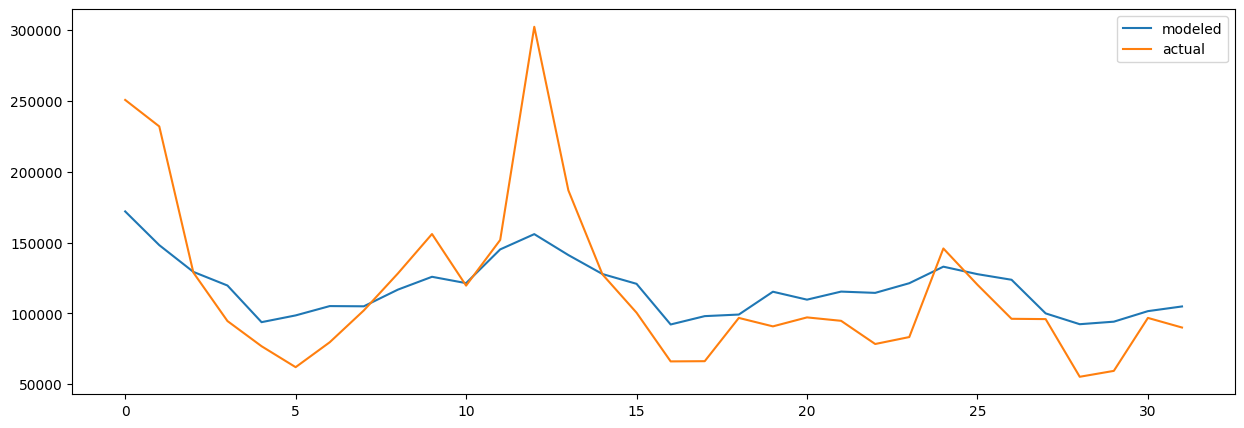

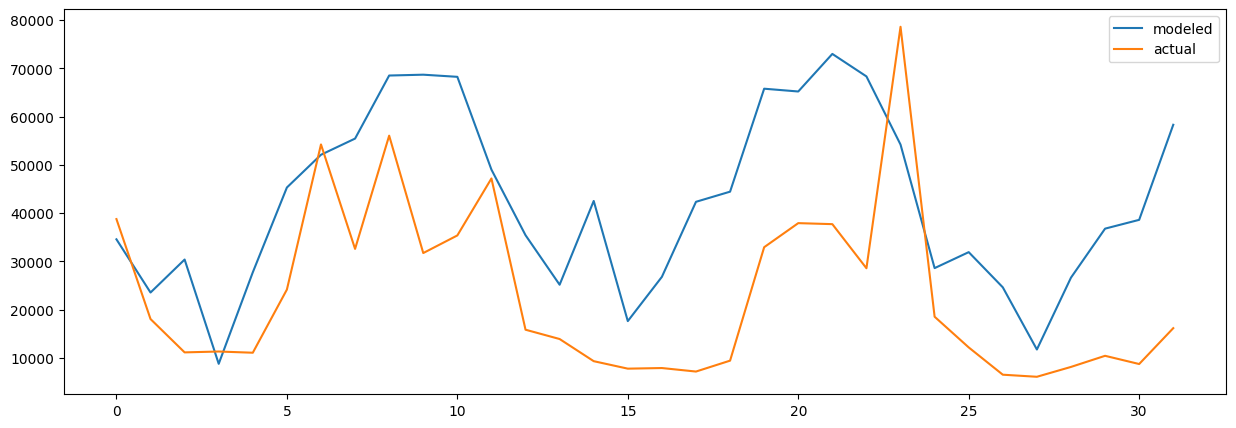

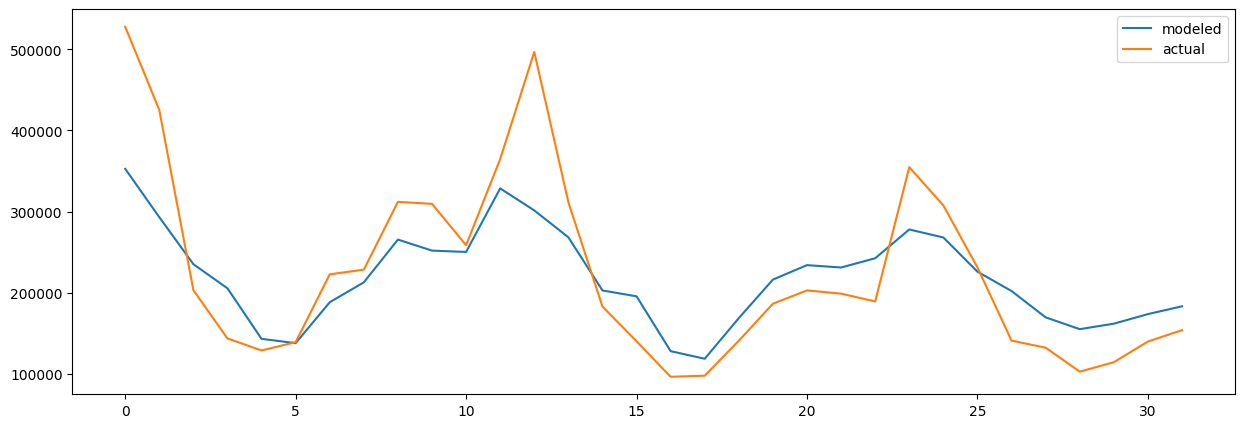

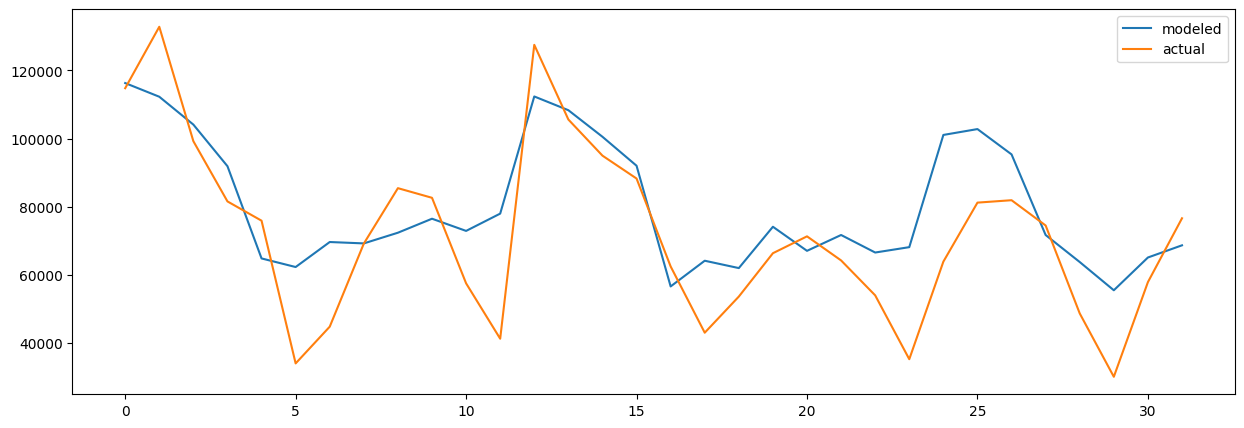

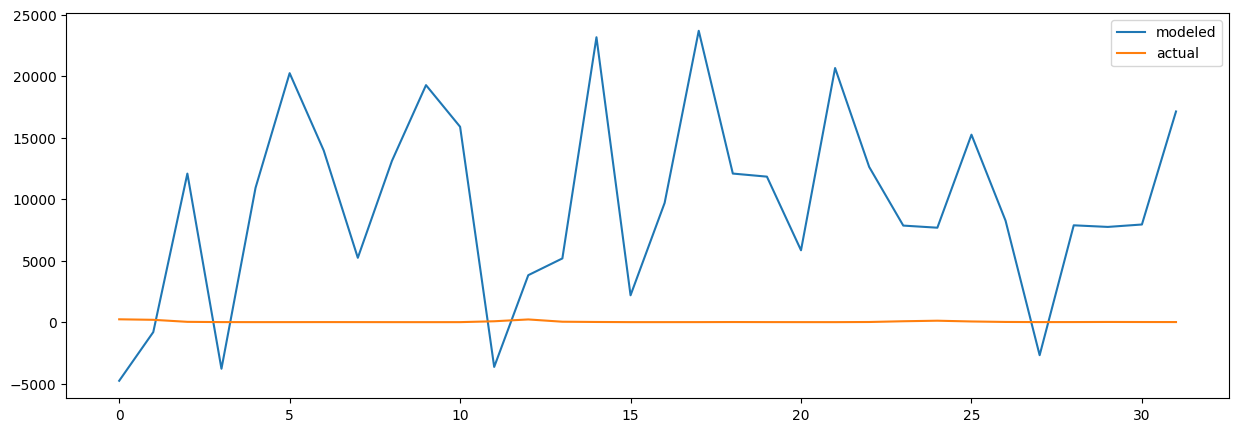

In [11]:
for i in range(model_sf.shape[-1]):
    
    plt.figure(figsize=(15,5))
    plt.plot(model_sf.cpu()[:,i])
    plt.plot(test_dset.tensors[-1].cpu().squeeze()[:,i])
    plt.legend(['modeled','actual'])
    plt.pause(1)

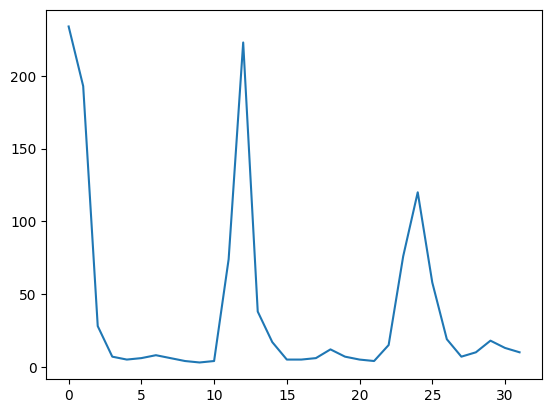

In [13]:
plt.plot(test_dset.tensors[-1].cpu().squeeze()[:,6])